<a href="https://colab.research.google.com/github/Leon7422/Online-store-analysis/blob/main/Online_store_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Налаштування та створення датасету за допомогою SQL через клієнта BigQuery (тех. частина)

In [ ]:
!pip install --upgrade google-cloud-bigquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-bigquery
    Found existing installation: google-cloud-bigquery 3.35.1
    Uninstalling google-cloud-bigquery-3.35.1:
      Successfully uninstalled google-cloud-bigquery-3.35.1


In [ ]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, mannwhitneyu, wilcoxon, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
auth.authenticate_user()

In [ ]:
client = bigquery.Client(project="data-analytics-mate")

In [ ]:
query = """
select
  s.date,
  o.ga_session_id as session_id,
  sp.continent,
  sp.country,
  sp.device,
  sp.browser,
  sp.mobile_model_name,
  sp.operating_system,
  sp.language,
  sp.medium as traffic_source,
  sp.channel,
  a.id as account_id,
  a.is_verified as is_email_verified,
  a.is_unsubscribed,
  p.category as product_category,
  p.name as product_name,
  p.price as product_price,
  p.short_description as product_description
from `DA.order` o
left join `DA.session` s
on o.ga_session_id = s.ga_session_id
left join `DA.session_params` sp
on sp.ga_session_id = o.ga_session_id
left join `DA.account_session` acs
on o.ga_session_id = acs.ga_session_id
left join `DA.account` a
on acs.account_id = a.id
left join `DA.product` p
on o.item_id = p.item_id
"""

In [ ]:
query_job = client.query(query)
results = query_job.result()


In [ ]:
df = results.to_dataframe()

In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
print(df)
print(df.dtypes)

            date  session_id continent        country   device  browser  \
0     2020-11-06  7799937037    Europe       Slovakia   mobile   Chrome   
1     2020-11-10  4020421879  Americas  United States  desktop   Chrome   
2     2020-11-24  6717382496  Americas  United States  desktop   Chrome   
3     2020-11-26  2093497337  Americas  United States  desktop   Chrome   
4     2020-12-03  9506718330    Europe          Spain  desktop   Chrome   
...          ...         ...       ...            ...      ...      ...   
33533 2021-01-05   748676938      Asia          India   mobile  <Other>   
33534 2021-01-10  7348756841  Americas  United States   mobile  <Other>   
33535 2021-01-12  5338559653    Europe          Spain  desktop   Chrome   
33536 2021-01-13  4599867597    Europe         France  desktop   Chrome   
33537 2021-01-23  8844815370  Americas  United States   mobile   Safari   

      mobile_model_name operating_system language traffic_source  \
0               <Other>        

#Поверхневий опис отриманого датасету

##Технічна частина

In [ ]:
#Кількість рядків та стовбців
print(df.shape)

(33538, 18)


In [ ]:
#К-сть та перелік числових колонок
int_columns = df.select_dtypes(include='number')
print(len(int_columns.columns))
print(int_columns.columns.tolist())

5
['session_id', 'account_id', 'is_email_verified', 'is_unsubscribed', 'product_price']


In [ ]:
#К-сть та перелік категоріальних колонок
category_columns = df.select_dtypes(include=['object', 'category'])
print(len(category_columns.columns))
print(category_columns.columns.tolist())

12
['continent', 'country', 'device', 'browser', 'mobile_model_name', 'operating_system', 'language', 'traffic_source', 'channel', 'product_category', 'product_name', 'product_description']


In [ ]:
#К-сть та перелік колонок дати
int_columns = df.select_dtypes(include='datetime64')
print(len(int_columns.columns))
print(int_columns.columns.tolist())

1
['date']


In [ ]:
#К-сть унікальних сесій
print(df['session_id'].nunique())

33538


In [ ]:
#Період датасету (Мін та макс дата)
print(df['date'].min())
print(df['date'].max())

2020-11-01 00:00:00
2021-01-27 00:00:00


In [ ]:
#Кількість пустих значень у стовпцях
print(df.isna().sum())

date                       0
session_id                 0
continent                  0
country                    0
device                     0
browser                    0
mobile_model_name          0
operating_system           0
language               11007
traffic_source             0
channel                    0
account_id             30757
is_email_verified      30757
is_unsubscribed        30757
product_category           0
product_name               0
product_price              0
product_description        0
dtype: int64


##Описова частина

Короткий опис датасету:


*   Загальна к-сть колонок - 18, з них:
  *   5 колонок числового типу:  
  'session_id', 'account_id', 'is_email_verified', 'is_unsubscribed', 'product_price'
  *   12 колонок категоріального типу:  
  'continent', 'country', 'device', 'browser', 'mobile_model_name', 'operating_system', 'language', 'traffic_source', 'channel', 'product_category', 'product_name', 'product_description'
  *    колонока типу datetime:  
  'date'
*   Кількість унікальних сесій - 33538
*   Період часу який розглядається - від 01.11.2020 до 27.01.2021
*   Кількість унікальних сесій - 33538
*   Назви колонок та кількість пропущених значень у них:

  *   language - 11007
  *   account_id - 30757
  *   is_email_verified - 30757
  *   is_unsubscribed - 30757  
    
Причиною пропущених значень у колонці Language можуть бути як небажання користувача ділитись інформацією про себе так і незмога розпізнати мову користувача програмно.  
Якщо ж говорити про account_id, is_email_verified та is_unsubscribed, це просто 30757 замовлень які зробили незареєстровані користувачі, тому у цих 3 колонках є пропущені значення які відповідають за реєстрацію користувача









#Статистичний аналіз отриманого датасету

##Технічна частина

In [ ]:
#Топ континентів по продажах ГРН:
sales_by_contients_uah = (
    df.groupby('continent')['product_price']
    .sum()
    .sort_values(ascending=False)
)

print(sales_by_contients_uah)

continent
Americas     17665280.0
Asia          7601298.3
Europe        5934624.2
Oceania        365230.2
Africa         331231.0
(not set)       74067.4
Name: product_price, dtype: float64


In [ ]:
#Топ країн по продажах ГРН
sales_by_countries_uah = (
    df.groupby('country')['product_price']
    .sum()
    .sort_values(ascending=False)
)

print(sales_by_countries_uah)

country
United States           13943553.9
India                    2809762.0
Canada                   2437921.0
United Kingdom            938317.9
France                    710692.8
                           ...    
Bahamas                     2411.0
Guatemala                   2259.0
Ghana                       1018.0
Bosnia & Herzegovina         939.0
Luxembourg                   879.0
Name: product_price, Length: 108, dtype: float64


In [ ]:
#Топ континентів по кількості замовлень:
sales_by_continents_cnt = (
    df.groupby('continent')
    .size()
    .sort_values(ascending=False)
)

print(sales_by_continents_cnt)

continent
Americas     18553
Asia          7950
Europe        6261
Oceania        364
Africa         339
(not set)       71
dtype: int64


In [ ]:
#Топ країн по кількості замовлень
sales_by_countries_cnt = (
    df.groupby('country')
    .size()
    .sort_values(ascending=False)
)

print(sales_by_countries_cnt)

country
United States           14673
India                    3029
Canada                   2560
United Kingdom           1029
France                    678
                        ...  
Bosnia & Herzegovina        5
Bahrain                     5
Honduras                    5
Bahamas                     4
Luxembourg                  3
Length: 108, dtype: int64


In [ ]:
#топ-10 категорій товарів за загальною сумою продажів
sales_by_category_uah = (
    df.groupby('product_category')['product_price']
    .sum()
    .sort_values(ascending=False)
)

print(sales_by_category_uah)

product_category
Sofas & armchairs                       8388254.5
Chairs                                  6147748.8
Beds                                    4919725.0
Bookcases & shelving units              3640818.1
Cabinets & cupboards                    2336499.5
Outdoor furniture                       2142222.2
Tables & desks                          1790307.5
Chests of drawers & drawer units         906562.5
Bar furniture                            735503.0
Children's furniture                     467697.0
Nursery furniture                        141607.0
Café furniture                           138168.0
Sideboards, buffets & console tables     126330.0
Room dividers                             90288.0
Name: product_price, dtype: float64


In [ ]:
#топ-10 категорій товарів у країні з найбільшими продажами(для порівняння)
top_country = df.groupby('country')['product_price'].sum().idxmax()
top_categories = (
    df[df['country'] == top_country]
    .groupby('product_category')['product_price']
    .sum()
    .sort_values(ascending=False)
)
print(top_categories)

product_category
Sofas & armchairs                       3707144.5
Chairs                                  2619773.8
Beds                                    2213058.0
Bookcases & shelving units              1567606.9
Cabinets & cupboards                     994545.5
Outdoor furniture                        929245.2
Tables & desks                           777865.0
Chests of drawers & drawer units         382388.0
Bar furniture                            330805.0
Children's furniture                     207575.0
Nursery furniture                         65998.0
Café furniture                            59000.0
Sideboards, buffets & console tables      58110.0
Room dividers                             30439.0
Name: product_price, dtype: float64


In [ ]:
#% розприділення продаж по типу девайсу
sales_by_device_type = df.groupby('device')['product_price'].sum()
total_sales = sales_by_device_type.sum()
device_type_sales_percent = (sales_by_device_type / total_sales * 100).round(2)
print(device_type_sales_percent)

device
desktop    59.00
mobile     38.73
tablet      2.26
Name: product_price, dtype: float64


In [ ]:
#% розприділення продаж по моделі девайсу
sales_by_device_model = df.groupby('mobile_model_name')['product_price'].sum()
total_sales = sales_by_device_model.sum()
device_model_sales_percent = (sales_by_device_model / total_sales * 100).round(2)
print(device_model_sales_percent)

mobile_model_name
<Other>       20.44
Chrome        27.84
ChromeBook     5.73
Edge           2.18
Firefox        1.32
Pixel 3        0.34
Pixel 4 XL     0.37
Safari        20.30
iPad           1.40
iPhone        20.08
Name: product_price, dtype: float64


In [ ]:
#% продажі за джерелами трафіку
sales_by_traffic_source = df.groupby('traffic_source')['product_price'].sum()
total_sales = sales_by_traffic_source.sum()
traffic_sales_percent = (sales_by_traffic_source / total_sales * 100).round(2)
print(traffic_sales_percent)

traffic_source
(data deleted)     6.39
(none)            23.44
<Other>           14.05
cpc                4.27
organic           34.20
referral          17.65
Name: product_price, dtype: float64


In [ ]:
#% підтверджених користувачів
unique_accounts = df['account_id'].nunique()
unique_accounts_verified = df[df['is_email_verified'] == 1]['account_id'].nunique()


print(unique_accounts_verified/unique_accounts * 100)


71.52103559870551


In [ ]:
#% зареєстрованих користувачів які відписались від розсилки
unique_accounts_unsubscribe = df[df['is_unsubscribed'] == 1]['account_id'].nunique()

print(unique_accounts_unsubscribe/unique_accounts_verified)

0.22473604826546004


In [ ]:
#Поведінка (у плані продажів) тих, хто відписався від розсилки та тих, хто досі підписаний
total_sales_subscribed = df[df['is_unsubscribed'] == 0]['product_price'].sum()
total_sales_unsubscribed = df[df['is_unsubscribed'] == 1]['product_price'].sum()

total_sales_subscribed_cnt = df[df['is_unsubscribed'] == 0]['session_id'].count()
total_sales_unsubscribed_cnt = df[df['is_unsubscribed'] == 1]['session_id'].count()

print(total_sales_subscribed/total_sales_subscribed_cnt)
print(total_sales_unsubscribed/total_sales_unsubscribed_cnt)

account_duplicates_count = (
    df[df['account_id'].notna()]
      .duplicated(subset=['account_id'], keep=False)
      .sum()
)
print(account_duplicates_count)

921.5068123393315
965.8201342281878
0


In [ ]:
#Топ 5 країн з найбільшою кількістю зареєстрованих користувачів
top_countries_verified = (
    df[df['is_email_verified'] == 1]
      .groupby('country', as_index=False)
      .agg(verified_count=('is_email_verified', 'count'))
      .sort_values('verified_count', ascending=False)
      .head(5)
      .reset_index(drop=True)
)

print(top_countries_verified)



          country  verified_count
0   United States             857
1           India             173
2          Canada             155
3  United Kingdom              59
4          France              45


##Описова частина


### Зведена інформація по продажах та замовленнях

#### Континенти
| Континент     | Продажі (ГРН) | Замовлення |
|---------------|---------------|------------|
| Americas      | 17,665,280    | 18,553     |
| Asia          | 7,601,298     | 7,950      |
| Europe        | 5,934,624     | 6,261      |
| Oceania       | 365,230       | 364        |
| Africa        | 331,231       | 339        |
| (not set)     | 74,067        | 71         |

#### Країни
| Країна          | Продажі (ГРН) | Замовлення |
|-----------------|---------------|------------|
| United States   | 13,943,553    | 14,673     |
| India           | 2,809,762     | 3,029      |
| Canada          | 2,437,921     | 2,560      |
| United Kingdom  | 938,318       | 1,029      |
| France          | 710,693       | 678        |

#### Висновки
- Основний обсяг продажів і замовлень зосереджений у Америці та США.
- Індія і Канада також показують значний внесок у продажі та кількість замовлень.
- Європа стабільно займає третє місце, а Африка та Океанія – найменш активні регіони.
- Частина даних не має прив’язки до конкретного континенту чи країни ((not set)), але їх обсяг невеликий.


### Зведена інформація по категоріях товарів

#### Топ-10 категорій за загальною сумою продажів
| Категорія товарів                         | Продажі (ГРН) |
|------------------------------------------|---------------|
| Sofas & armchairs                         | 8,388,254     |
| Chairs                                    | 6,147,748     |
| Beds                                      | 4,919,725     |
| Bookcases & shelving units                | 3,640,818     |
| Cabinets & cupboards                      | 2,336,499     |
| Outdoor furniture                         | 2,142,222     |
| Tables & desks                            | 1,790,308     |
| Chests of drawers & drawer units          | 906,562       |
| Bar furniture                             | 735,503       |
| Children's furniture                      | 467,697       |

#### Топ-10 категорій у країні з найбільшими продажами (United States)
| Категорія товарів                         | Продажі (ГРН) |
|------------------------------------------|---------------|
| Sofas & armchairs                         | 3,707,145     |
| Chairs                                    | 2,619,774     |
| Beds                                      | 2,213,058     |
| Bookcases & shelving units                | 1,567,607     |
| Cabinets & cupboards                      | 994,546       |
| Outdoor furniture                         | 929,245       |
| Tables & desks                            | 777,865       |
| Chests of drawers & drawer units          | 382,388       |
| Bar furniture                             | 330,805       |
| Children's furniture                      | 207,575       |

#### Висновки
- Лідери за продажами – меблі для сидіння та спальні: **Sofas & armchairs, Chairs, Beds**.
- Топ-10 категорій формують основну частку продажів, інші категорії мають порівняно невеликі обсяги.
- Структура продажів у США повторює загальну картину, але з великим домінуванням **Sofas & armchairs**.
- Продажі меблів для дітей і барні меблі займають найменшу частку серед топ-10 категорій.


### Аналіз продажів за девайсами та джерелами трафіку

#### Розподіл продажів по типу девайсу
| Тип девайсу | % від загальних продажів |
|-------------|-------------------------|
| Desktop     | 59.00                   |
| Mobile      | 38.73                   |
| Tablet      | 2.26                    |

#### Розподіл продажів по моделі девайсу
| Модель девайсу | % від загальних продажів |
|----------------|-------------------------|
| Chrome         | 27.84                   |
| Safari         | 20.30                   |
| iPhone         | 20.08                   |
| <Other>        | 20.44                   |
| ChromeBook     | 5.73                    |
| Edge           | 2.18                    |
| Firefox        | 1.32                    |
| iPad           | 1.40                    |
| Pixel 3        | 0.34                    |
| Pixel 4 XL     | 0.37                    |

#### Розподіл продажів за джерелами трафіку
| Джерело трафіку | % від загальних продажів |
|-----------------|-------------------------|
| Organic         | 34.20                   |
| (none)          | 23.44                   |
| <Other>         | 14.05                   |
| <data deleted>  | 6.39                    |
| CPC             | 4.27                    |

#### Короткі висновки
- **Більшість продажів здійснюється з десктопів** (59%), мобільні девайси також важливі (38.7%), планшети – незначна частка (2.3%).  
- **Найпопулярніші моделі для покупок**: Chrome, Safari, iPhone, разом вони формують майже 70% продажів.  
- **Основне джерело трафіку – органічний пошук** (34%), частка прямих заходів (none) – 23.4%. Реклама через CPC дає менше 5% продажів.  
- Висновок: варто оптимізувати сайт для десктопів і мобільних, особливо для Chrome та Safari, а також підтримувати органічний трафік і прямі заходи.


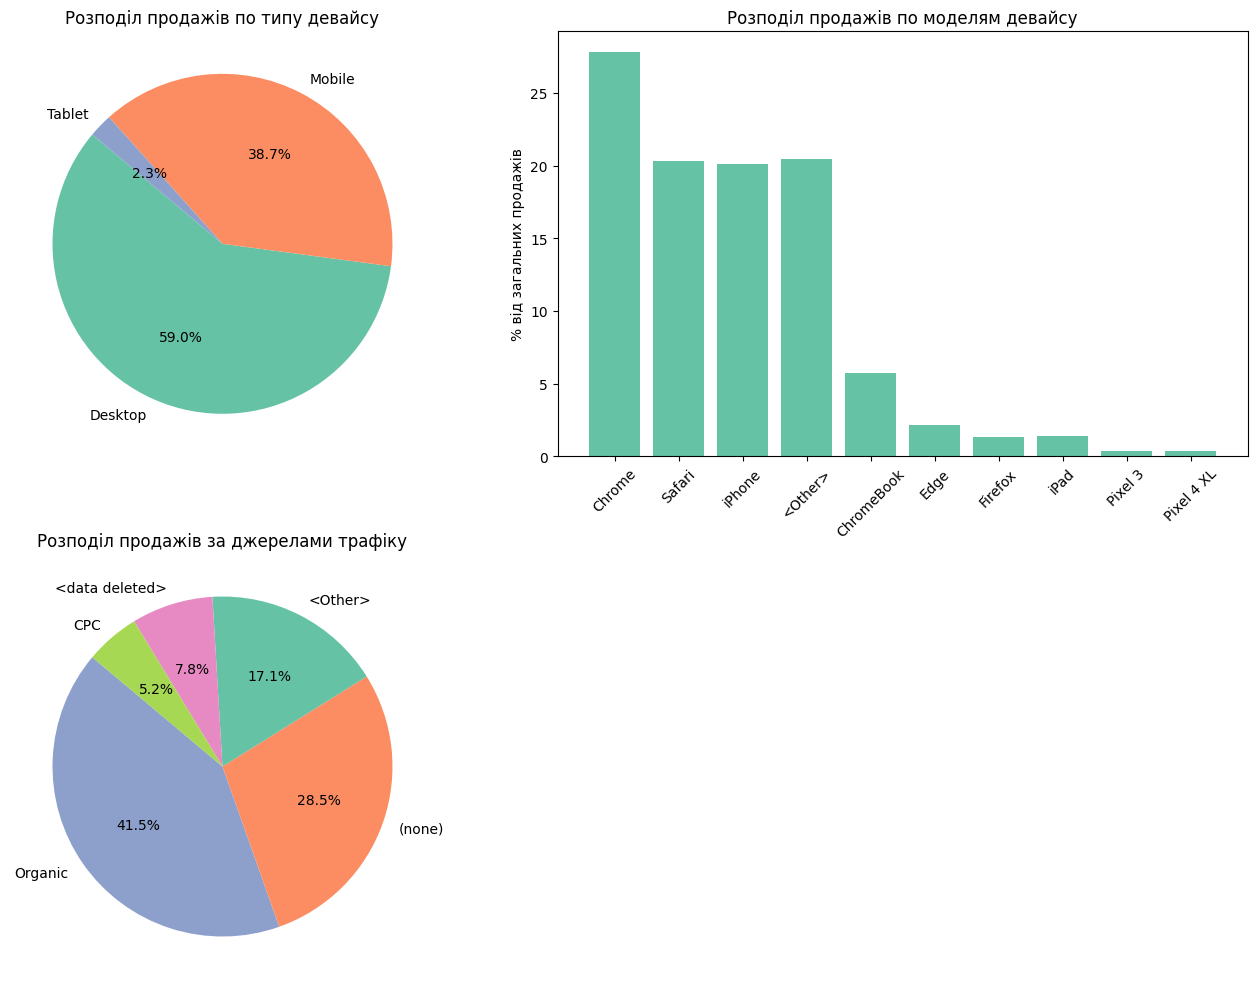

In [ ]:
device_type = ['Desktop', 'Mobile', 'Tablet']
device_type_pct = [59.00, 38.73, 2.26]

device_model = ['Chrome', 'Safari', 'iPhone', '<Other>', 'ChromeBook', 'Edge', 'Firefox', 'iPad', 'Pixel 3', 'Pixel 4 XL']
device_model_pct = [27.84, 20.30, 20.08, 20.44, 5.73, 2.18, 1.32, 1.40, 0.34, 0.37]

traffic_source = ['Organic', '(none)', '<Other>', '<data deleted>', 'CPC']
traffic_source_pct = [34.20, 23.44, 14.05, 6.39, 4.27]

fig, axs = plt.subplots(2, 2, figsize=(14,10))
fig.delaxes(axs[1,1])  # Видаляємо зайвий підграфік

axs[0,0].pie(device_type_pct, labels=device_type, autopct='%1.1f%%', startangle=140, colors=['#66c2a5','#fc8d62','#8da0cb'])
axs[0,0].set_title('Розподіл продажів по типу девайсу')

axs[0,1].bar(device_model, device_model_pct, color='#66c2a5')
axs[0,1].set_title('Розподіл продажів по моделям девайсу')
axs[0,1].set_ylabel('% від загальних продажів')
axs[0,1].tick_params(axis='x', rotation=45)

axs[1,0].pie(traffic_source_pct, labels=traffic_source, autopct='%1.1f%%', startangle=140, colors=['#8da0cb','#fc8d62','#66c2a5','#e78ac3','#a6d854'])
axs[1,0].set_title('Розподіл продажів за джерелами трафіку')

plt.tight_layout()
plt.show()


### Аналіз користувачів

#### Основні показники
| Показник                                           | Значення |
|---------------------------------------------------|----------|
| % підтверджених користувачів                      | 71.52%   |
| % зареєстрованих користувачів, які відписались від розсилки | 0.22%    |
| Середні продажі підписаних на розсилку           | 921.51   |
| Середні продажі непідписаних на розсилку         | 965.82   |

#### Топ-5 країн за кількістю зареєстрованих користувачів
| Країна          | Кількість користувачів |
|-----------------|-----------------------|
| United States   | 857                   |
| India           | 173                   |
| Canada          | 155                   |
| United Kingdom  | 59                    |
| France          | 45                    |

#### Короткі висновки
- Більшість користувачів підтверджені (71.5%), відписка від розсилки майже відсутня (0.22%).  
- Середні продажі непідписаних трохи вищі за підписаних, що може вказувати на незначний вплив розсилки на середній чек.  
- Основна маса користувачів зосереджена в США, далі йдуть Індія та Канада.


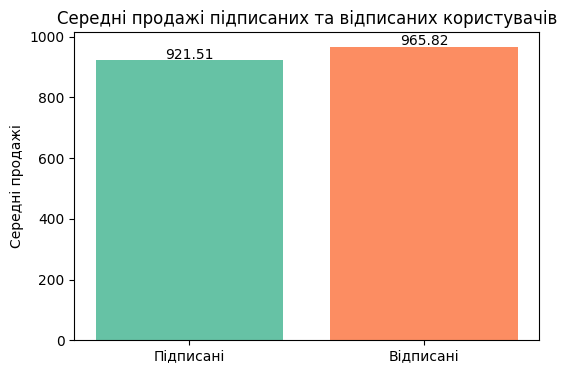

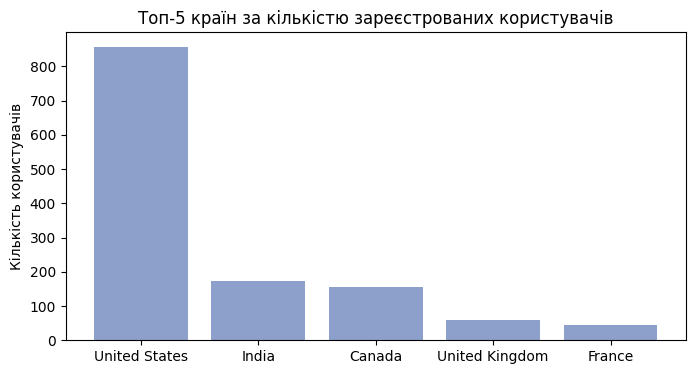

In [ ]:
user_status = ['Підписані', 'Відписані']
avg_sales = [921.51, 965.82]

top_countries = ['United States', 'India', 'Canada', 'United Kingdom', 'France']
user_counts = [857, 173, 155, 59, 45]

plt.figure(figsize=(6,4))
plt.bar(user_status, avg_sales, color=['#66c2a5','#fc8d62'])
plt.ylabel('Середні продажі')
plt.title('Середні продажі підписаних та відписаних користувачів')
for i, v in enumerate(avg_sales):
    plt.text(i, v + 5, f"{v:.2f}", ha='center')
plt.show()

plt.figure(figsize=(8,4))
plt.bar(top_countries, user_counts, color='#8da0cb')
plt.ylabel('Кількість користувачів')
plt.title('Топ-5 країн за кількістю зареєстрованих користувачів')
plt.show()


#Аналіз динаміки продажів

##Динаміка продаж по днях

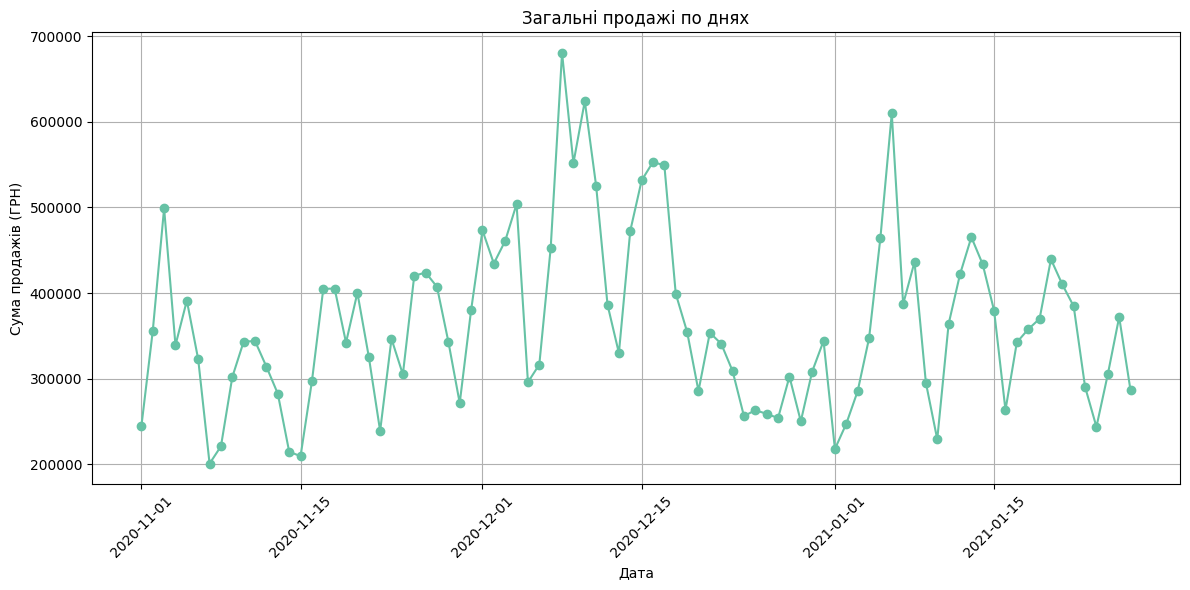

In [ ]:
daily_sales = df.groupby('date')['product_price'].sum()

plt.figure(figsize=(12,6))
plt.plot(daily_sales.index, daily_sales.values, marker='o', color='#66c2a5')
plt.title('Загальні продажі по днях')
plt.xlabel('Дата')
plt.ylabel('Сума продажів (ГРН)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Опис:  

Продажі підвищуються у певні періоди, наприклад на початку грудня і на початку січня.

Це може вказувати на сезонні фактори, пов’язані зі святами (Чорна п’ятниця, передноворічні покупки).

Регулярні коливання:

Між піками продажів є більш спокійні дні з нижчими обсягами.

Це може свідчити про тижневий цикл (наприклад, продажі можуть падати у вихідні або навпаки зростати).

Тренд:

Загальна тенденція не демонструє чіткої стабільної зростаючої або спадаючої лінії – переважають коливання навколо певного рівня (≈ 300–400 тис. грн).  
  
Сезонність у продажах спостерігається, особливо у святкові періоди (кінець року), а також можуть бути регулярні коливання протягом тижня.

##Динаміка продаж по Континентах

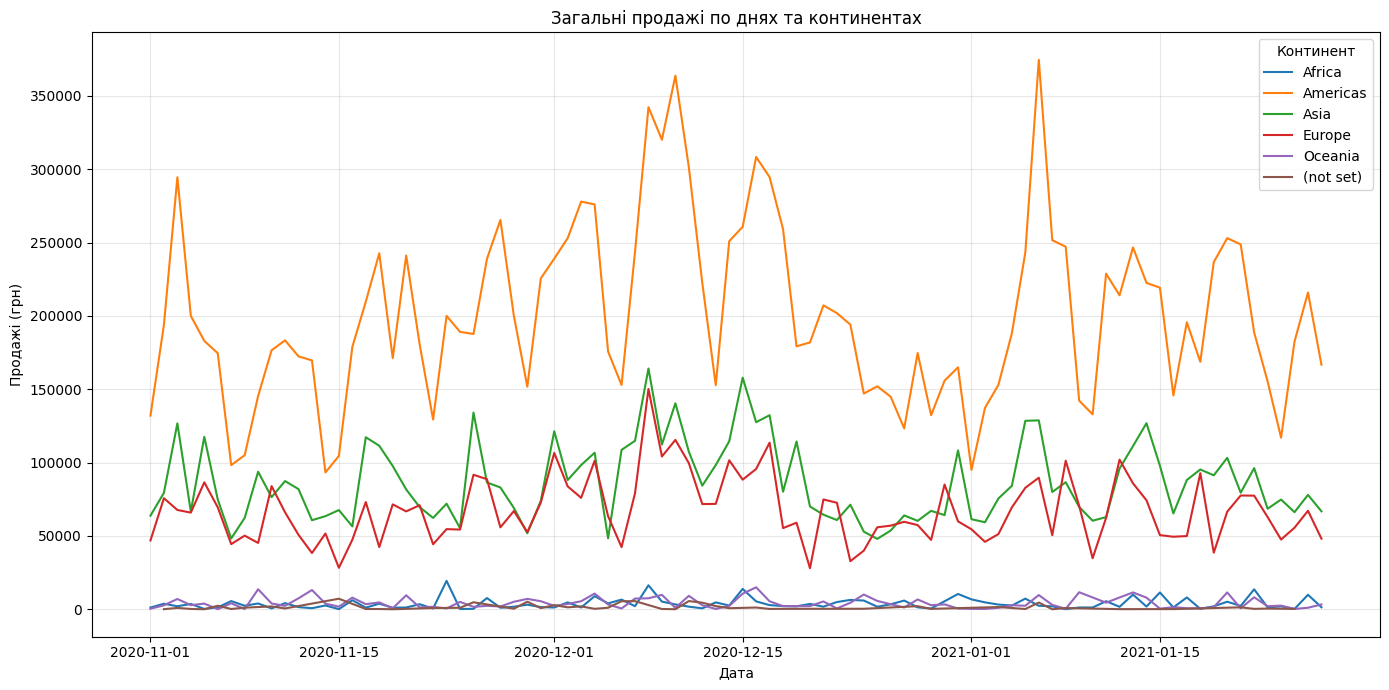

In [ ]:
sales_by_day_continent = (
    df.groupby(["date", "continent"])["product_price"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(14, 7))

for continent in sales_by_day_continent["continent"].unique():
    subset = sales_by_day_continent[sales_by_day_continent["continent"] == continent]
    plt.plot(
        subset["date"],
        subset["product_price"],
        label=continent
    )

plt.title("Загальні продажі по днях та континентах")
plt.xlabel("Дата")
plt.ylabel("Продажі (грн)")
plt.legend(title="Континент")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Висновки:

Основні продажі генеруються з американського ринку — варто фокусувати маркетингові зусилля на ньому.

Європа та Азія — важливі другорядні ринки. Можуть стати джерелом росту за умови таргетованих кампаній.

Інші регіони наразі не є значущими — потенціал зростання, але потрібен окремий підхід.

##Динаміка продаж по Каналах

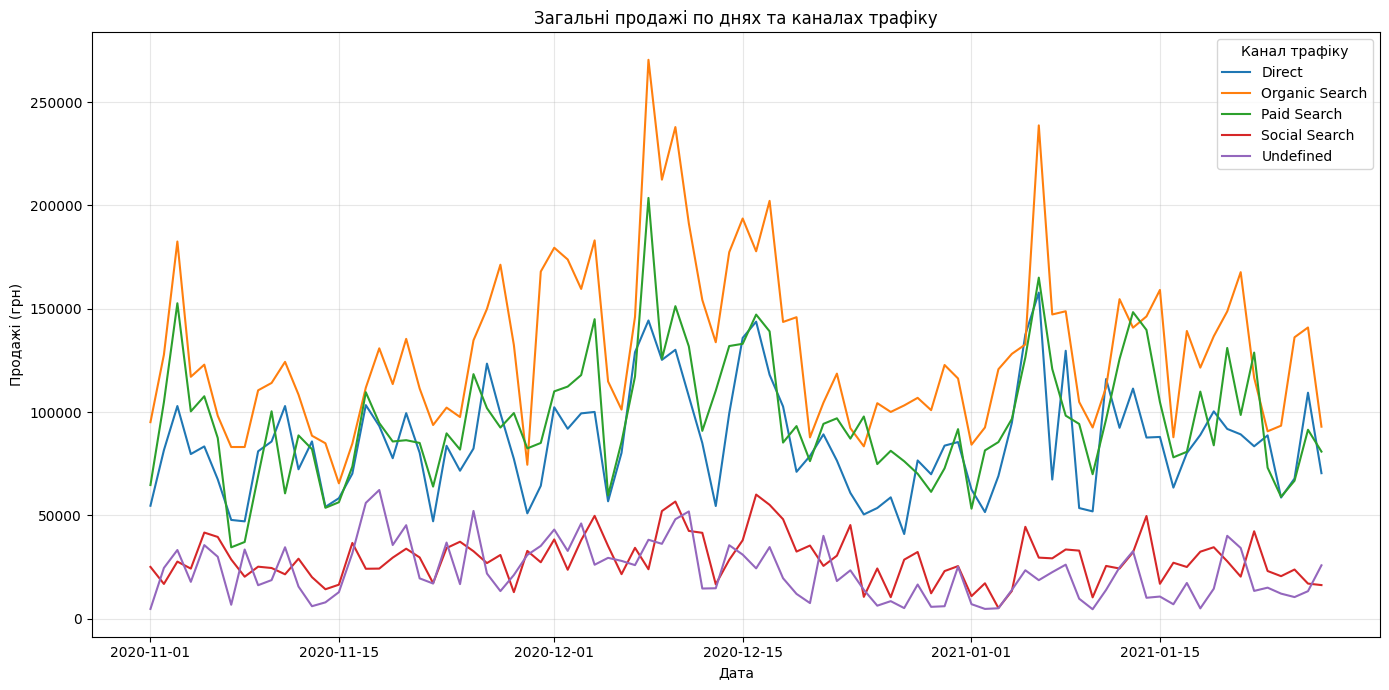

In [ ]:
sales_by_day_channel = (
    df.groupby(["date", "channel"])["product_price"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(14, 7))

for channel in sales_by_day_channel["channel"].unique():
    subset = sales_by_day_channel[sales_by_day_channel["channel"] == channel]
    plt.plot(
        subset["date"],
        subset["product_price"],
        label=channel
    )

plt.title("Загальні продажі по днях та каналах трафіку")
plt.xlabel("Дата")
plt.ylabel("Продажі (грн)")
plt.legend(title="Канал трафіку")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Висновки:

Найефективніший канал — органічний пошук, отже, SEO-стратегія працює і її варто розвивати.

Контекстна реклама (Paid Search) дає добрі результати, але її потрібно оптимізувати через нестабільність.

Соціальні мережі та невизначені джерела — потенційні зони росту, проте поки мають малий вплив.

##Динаміка продаж по Типах девайсів

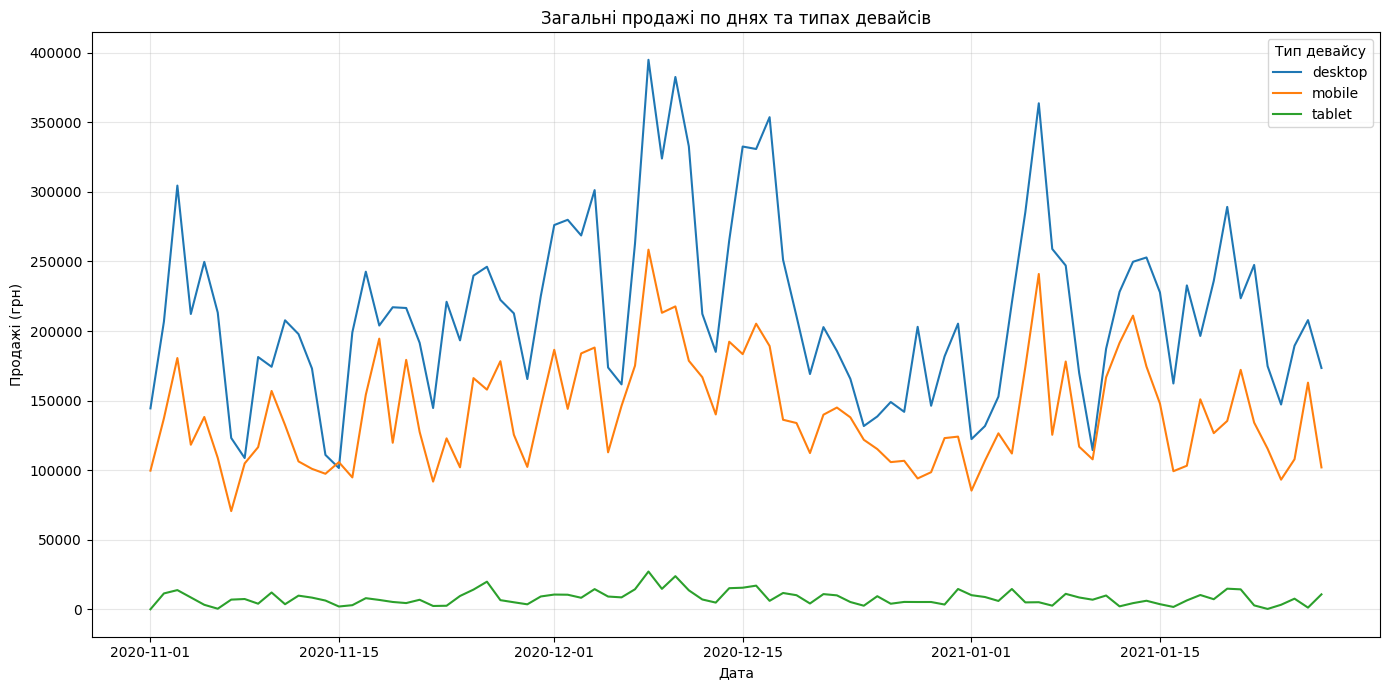

In [ ]:
sales_by_day_device = (
    df.groupby(["date", "device"])["product_price"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(14, 7))

for device in sales_by_day_device["device"].unique():
    subset = sales_by_day_device[sales_by_day_device["device"] == device]
    plt.plot(
        subset["date"],
        subset["product_price"],
        label=device
    )

plt.title("Загальні продажі по днях та типах девайсів")
plt.xlabel("Дата")
plt.ylabel("Продажі (грн)")
plt.legend(title="Тип девайсу")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Висновки:

Основна частина доходу надходить із десктопів — очевидно, користувачі частіше завершують покупки саме з комп’ютерів.

Мобільний трафік слід розглядати як підтримуючий канал — можливо, користувачі переглядають товари з телефону, але купують з ПК.

Інвестувати в покращення desktop-версії сайту має пріоритет. Tablet можна розглядати як низькоприбутковий сегмент.

##Загальні рекомендації



* Зосередьте інвестиції на desktop-версії сайту, оскільки вона генерує більшість доходів.

* Продовжуйте оптимізацію SEO — органічний трафік приносить найбільше продажів.

* Американський ринок — ключовий, але не варто ігнорувати потенціал Європи та Азії.

* Проведіть аудит слабких каналів (Social, Undefined) — можливо, потрібно змінити підхід або аналітику.

* Розгляньте крос-платформену стратегію, щоб з’єднати мобільний перегляд і завершення покупок на desktop.



#Зведені таблиці

##Кількість сесій у розрізі каналів трафіку та типів девайсів

In [ ]:
df_filtered1 = df.dropna(subset=['channel', 'device', 'session_id'])

df_filtered1 = df_filtered1.drop_duplicates(subset=['session_id'])

pivot_table = df_filtered1.pivot_table(
    index='channel',
    columns='device',
    values='session_id',
    aggfunc='count',
    fill_value=0
)

pivot_table

device,desktop,mobile,tablet
channel,,,
Direct,4655,2985,160
Organic Search,7011,4655,255
Paid Search,5261,3574,207
Social Search,1594,1065,57
Undefined,1181,834,44


##Загальні продажі за категоріями товарів (топ-10 категорій) у різних країнах (топ-5 країн)


In [ ]:
df_filtered2 = df.dropna(subset=['country', 'product_category', 'product_price'])

df_filtered2['product_price'] = pd.to_numeric(df_filtered2['product_price'], errors='coerce')
df_filtered2 = df_filtered2.dropna(subset=['product_price'])

top_categories = (
    df_filtered2.groupby('product_category')['product_price']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

top_countries = (
    df_filtered2.groupby('country')['product_price']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

df_top = df_filtered2[
    df_filtered2['product_category'].isin(top_categories) &
    df_filtered2['country'].isin(top_countries)
]

pivot_table = df_top.pivot_table(
    index='product_category',
    columns='country',
    values='product_price',
    aggfunc='sum',
    fill_value=0
)

country_order = pivot_table.sum(axis=0).sort_values(ascending=False).index
pivot_table = pivot_table[country_order]

total_row = pd.DataFrame(pivot_table.sum(axis=0)).T
total_row.index = ['Total']

pivot_table = pd.concat([pivot_table, total_row])

pivot_table_formatted = pivot_table.map(lambda x: '{:,.0f}'.format(x).replace(',', ' '))

pivot_table_formatted

country,United States,India,Canada,United Kingdom,France
Bar furniture,330 805,57 657,51 724,22 103,11 199
Beds,2 213 058,358 320,354 772,133 816,116 414
Bookcases & shelving units,1 567 607,364 507,278 982,113 988,73 830
Cabinets & cupboards,994 546,191 888,181 802,71 684,59 102
Chairs,2 619 774,544 309,417 741,188 519,134 029
Chests of drawers & drawer units,382 388,73 111,71 952,36 784,21 544
Children's furniture,207 575,39 177,30 264,13 348,14 258
Outdoor furniture,929 245,162 289,185 323,57 002,40 486
Sofas & armchairs,3 707 144,788 430,692 428,234 812,187 735
Tables & desks,777 865,186 158,132 678,49 374,42 299


#Статистичний аналіз взаємозв'язків

##Взаємозв’язок між кількістю сесіями та загальними продажами на кожну дату

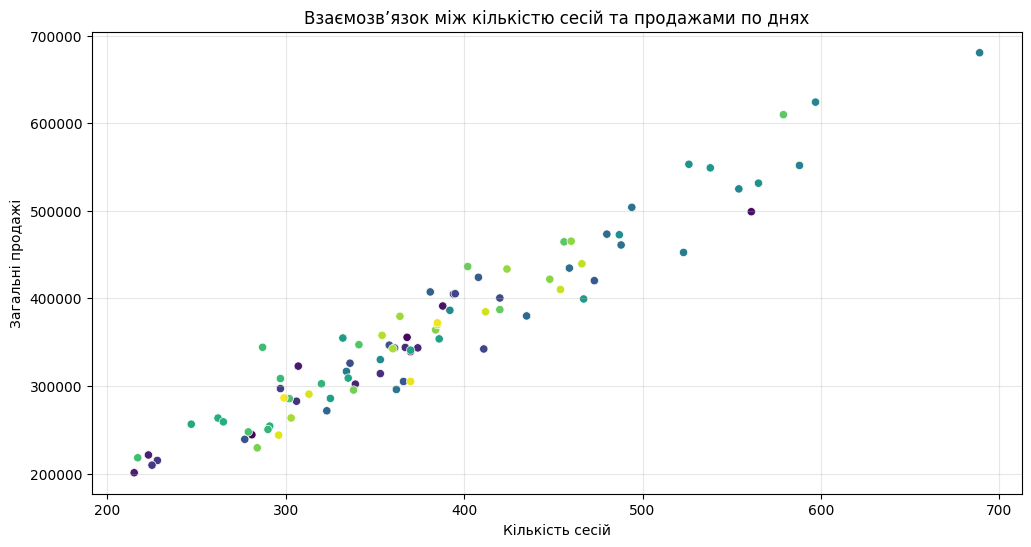

Коефіцієнт кореляції Пірсона: 0.964
P-value: 0.00000
Висновок: кореляція 0.964, статистично значуща (p < 0.05).


In [ ]:
daily_stats = df.groupby("date").agg(
    sessions=("session_id", "nunique"),
    sales=("product_price", "sum")
).reset_index()

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=daily_stats,
    x="sessions",
    y="sales",
    hue="date",
    palette="viridis",
    legend=False
)
plt.title("Взаємозв’язок між кількістю сесій та продажами по днях")
plt.xlabel("Кількість сесій")
plt.ylabel("Загальні продажі")
plt.grid(alpha=0.3)
plt.show()

corr_coef, p_value = pearsonr(daily_stats["sessions"], daily_stats["sales"])

print(f"Коефіцієнт кореляції Пірсона: {corr_coef:.3f}")
print(f"P-value: {p_value:.5f}")

if p_value < 0.05:
    significance = "статистично значуща (p < 0.05)"
else:
    significance = "НЕ є статистично значущою (p ≥ 0.05)"

print(f"Висновок: кореляція {corr_coef:.3f}, {significance}.")


##Взаємозв’язок між кількістю сесіями та загальними продажами на кожну дату по  топ-3 каналах

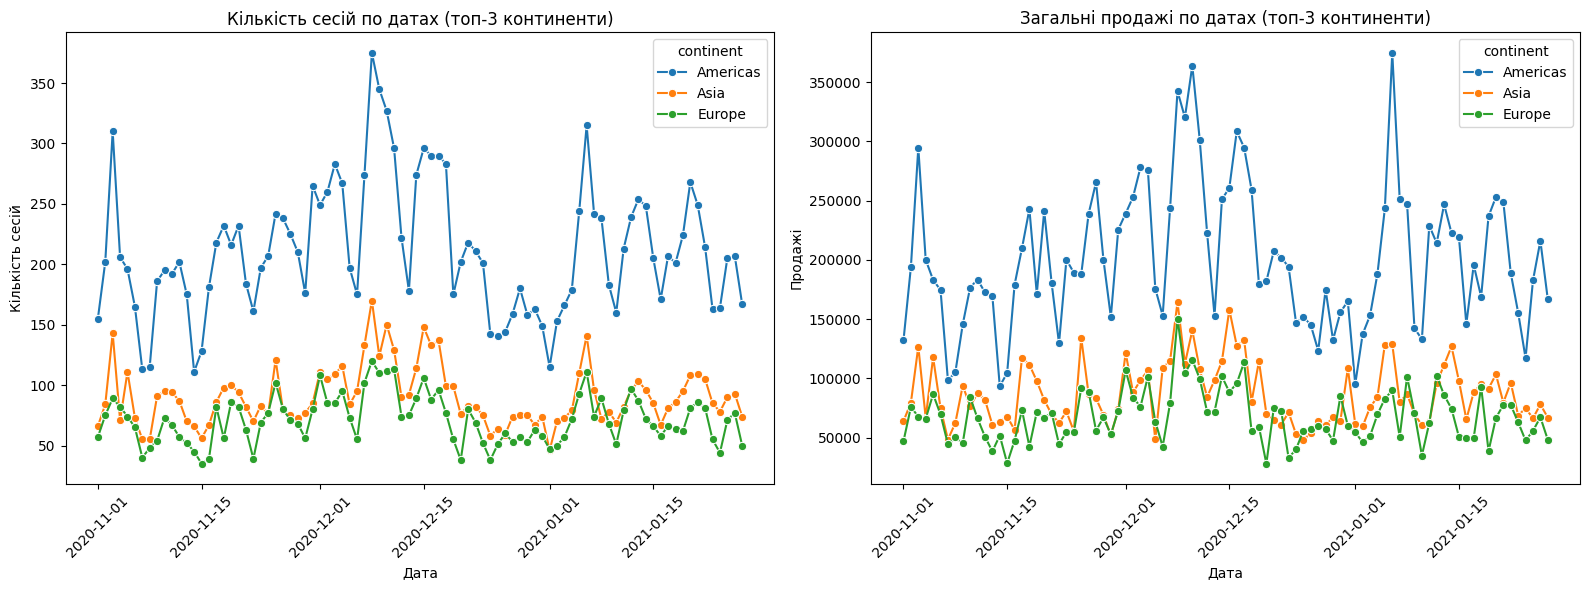


Континент: Americas
Коефіцієнт кореляції Пірсона: 0.948
P-value: 1.915e-44
Кореляція статистично значуща на рівні 0.05

Континент: Asia
Коефіцієнт кореляції Пірсона: 0.869
P-value: 4.676e-28
Кореляція статистично значуща на рівні 0.05

Континент: Europe
Коефіцієнт кореляції Пірсона: 0.857
P-value: 1.838e-26
Кореляція статистично значуща на рівні 0.05


In [ ]:
agg_df = df.groupby(['date', 'continent']).agg(
    sessions=('session_id', 'nunique'),
    total_sales=('product_price', 'sum')
).reset_index()

top_continents = agg_df.groupby('continent')['total_sales'].sum().sort_values(ascending=False).head(3).index.tolist()

agg_top_df = agg_df[agg_df['continent'].isin(top_continents)]

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=agg_top_df, x='date', y='sessions', hue='continent', marker='o')
plt.title('Кількість сесій по датах (топ-3 континенти)')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Кількість сесій')

plt.subplot(1, 2, 2)
sns.lineplot(data=agg_top_df, x='date', y='total_sales', hue='continent', marker='o')
plt.title('Загальні продажі по датах (топ-3 континенти)')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Продажі')

plt.tight_layout()
plt.show()

for cont in top_continents:
    subset = agg_top_df[agg_top_df['continent'] == cont]
    corr_coef, p_value = pearsonr(subset['sessions'], subset['total_sales'])
    print(f"\nКонтинент: {cont}")
    print(f"Коефіцієнт кореляції Пірсона: {corr_coef:.3f}")
    print(f"P-value: {p_value:.3e}")
    if p_value < 0.05:
        print("Кореляція статистично значуща на рівні 0.05")
    else:
        print("Кореляція не є статистично значущою на рівні 0.05")


##Взаємозв’язок між кількістю сесій та загальними продажами на кожну дату по  каналах

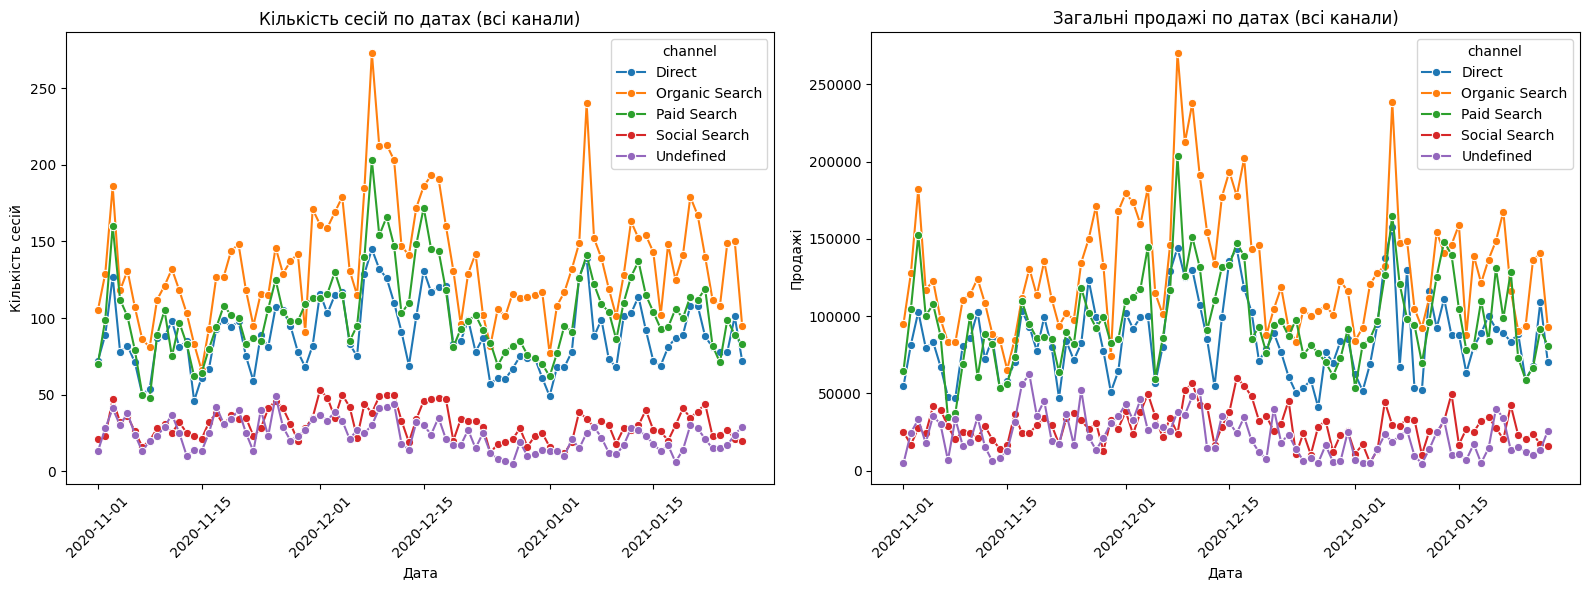


Канал: Direct
Коефіцієнт кореляції Пірсона: 0.878
P-value: 2.899e-29
Кореляція статистично значуща на рівні 0.05

Канал: Organic Search
Коефіцієнт кореляції Пірсона: 0.953
P-value: 3.029e-46
Кореляція статистично значуща на рівні 0.05

Канал: Paid Search
Коефіцієнт кореляції Пірсона: 0.896
P-value: 5.010e-32
Кореляція статистично значуща на рівні 0.05

Канал: Social Search
Коефіцієнт кореляції Пірсона: 0.759
P-value: 9.828e-18
Кореляція статистично значуща на рівні 0.05

Канал: Undefined
Коефіцієнт кореляції Пірсона: 0.866
P-value: 1.209e-27
Кореляція статистично значуща на рівні 0.05


In [ ]:
agg_df = df.groupby(['date', 'channel']).agg(
    sessions=('session_id', 'nunique'),
    total_sales=('product_price', 'sum')
).reset_index()

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=agg_df, x='date', y='sessions', hue='channel', marker='o')
plt.title('Кількість сесій по датах (всі канали)')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Кількість сесій')

plt.subplot(1, 2, 2)
sns.lineplot(data=agg_df, x='date', y='total_sales', hue='channel', marker='o')
plt.title('Загальні продажі по датах (всі канали)')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Продажі')

plt.tight_layout()
plt.show()

channels = agg_df['channel'].unique()

for ch in channels:
    subset = agg_df[agg_df['channel'] == ch]
    corr_coef, p_value = pearsonr(subset['sessions'], subset['total_sales'])
    print(f"\nКанал: {ch}")
    print(f"Коефіцієнт кореляції Пірсона: {corr_coef:.3f}")
    print(f"P-value: {p_value:.3e}")
    if p_value < 0.05:
        print("Кореляція статистично значуща на рівні 0.05")
    else:
        print("Кореляція не є статистично значущою на рівні 0.05")


##Взаємозв’язок між кількістю сесій та загальними продажами на кожну дату по топ-5 категорій товарів

Топ-5 категорій за продажами: ['Sofas & armchairs', 'Chairs', 'Beds', 'Bookcases & shelving units', 'Cabinets & cupboards']


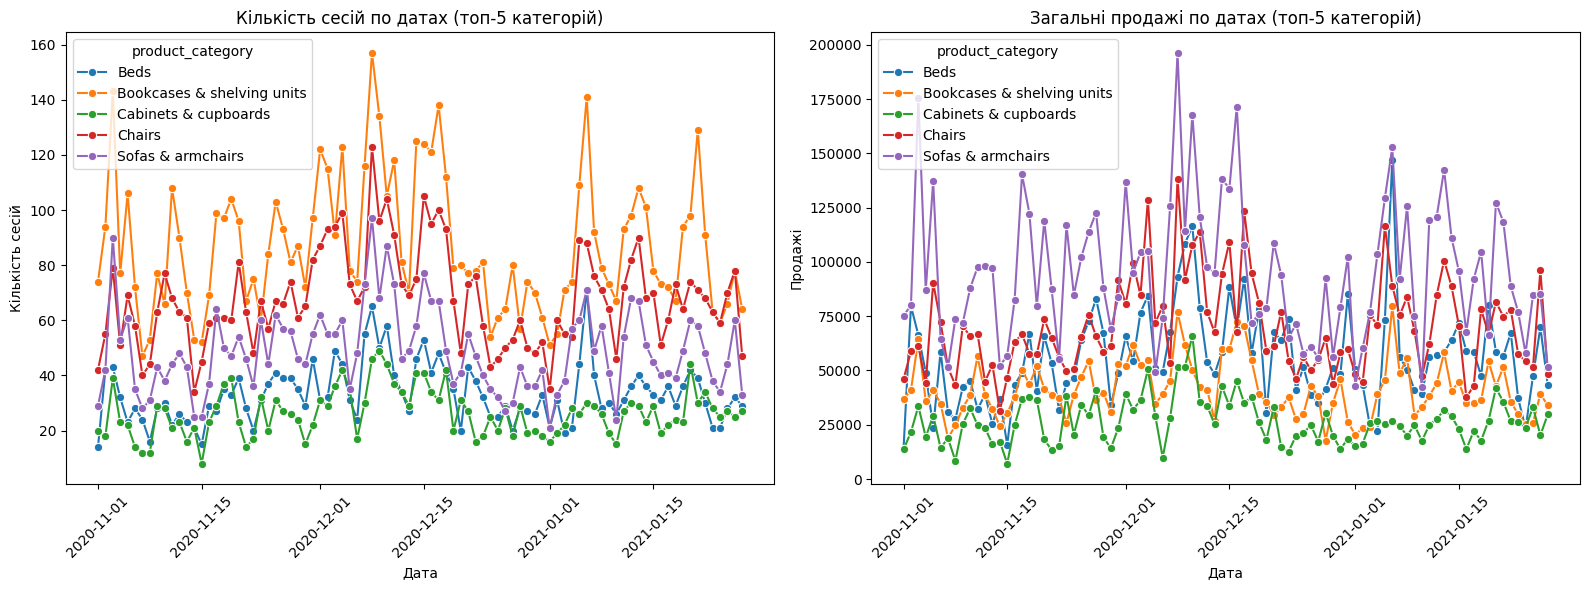


Категорія товару: Sofas & armchairs
Коефіцієнт кореляції Пірсона: 0.900
P-value: 7.869e-33
Кореляція статистично значуща на рівні 0.05

Категорія товару: Chairs
Коефіцієнт кореляції Пірсона: 0.851
P-value: 8.188e-26
Кореляція статистично значуща на рівні 0.05

Категорія товару: Beds
Коефіцієнт кореляції Пірсона: 0.858
P-value: 1.442e-26
Кореляція статистично значуща на рівні 0.05

Категорія товару: Bookcases & shelving units
Коефіцієнт кореляції Пірсона: 0.888
P-value: 1.064e-30
Кореляція статистично значуща на рівні 0.05

Категорія товару: Cabinets & cupboards
Коефіцієнт кореляції Пірсона: 0.866
P-value: 1.129e-27
Кореляція статистично значуща на рівні 0.05


In [ ]:
agg_df = df.groupby(['date', 'product_category']).agg(
    sessions=('session_id', 'nunique'),
    total_sales=('product_price', 'sum')
).reset_index()

top_categories = agg_df.groupby('product_category')['total_sales'].sum().sort_values(ascending=False).head(5).index.tolist()
print(f"Топ-5 категорій за продажами: {top_categories}")

agg_top_df = agg_df[agg_df['product_category'].isin(top_categories)]

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=agg_top_df, x='date', y='sessions', hue='product_category', marker='o')
plt.title('Кількість сесій по датах (топ-5 категорій)')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Кількість сесій')

plt.subplot(1, 2, 2)
sns.lineplot(data=agg_top_df, x='date', y='total_sales', hue='product_category', marker='o')
plt.title('Загальні продажі по датах (топ-5 категорій)')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Продажі')

plt.tight_layout()
plt.show()

for cat in top_categories:
    subset = agg_top_df[agg_top_df['product_category'] == cat]
    corr_coef, p_value = pearsonr(subset['sessions'], subset['total_sales'])
    print(f"\nКатегорія товару: {cat}")
    print(f"Коефіцієнт кореляції Пірсона: {corr_coef:.3f}")
    print(f"P-value: {p_value:.3e}")
    if p_value < 0.05:
        print("Кореляція статистично значуща на рівні 0.05")
    else:
        print("Кореляція не є статистично значущою на рівні 0.05")


#Статистичний аналіз відмінностей між групами

##Відмінності між зареєстрованими та незареєстрованими користувачами

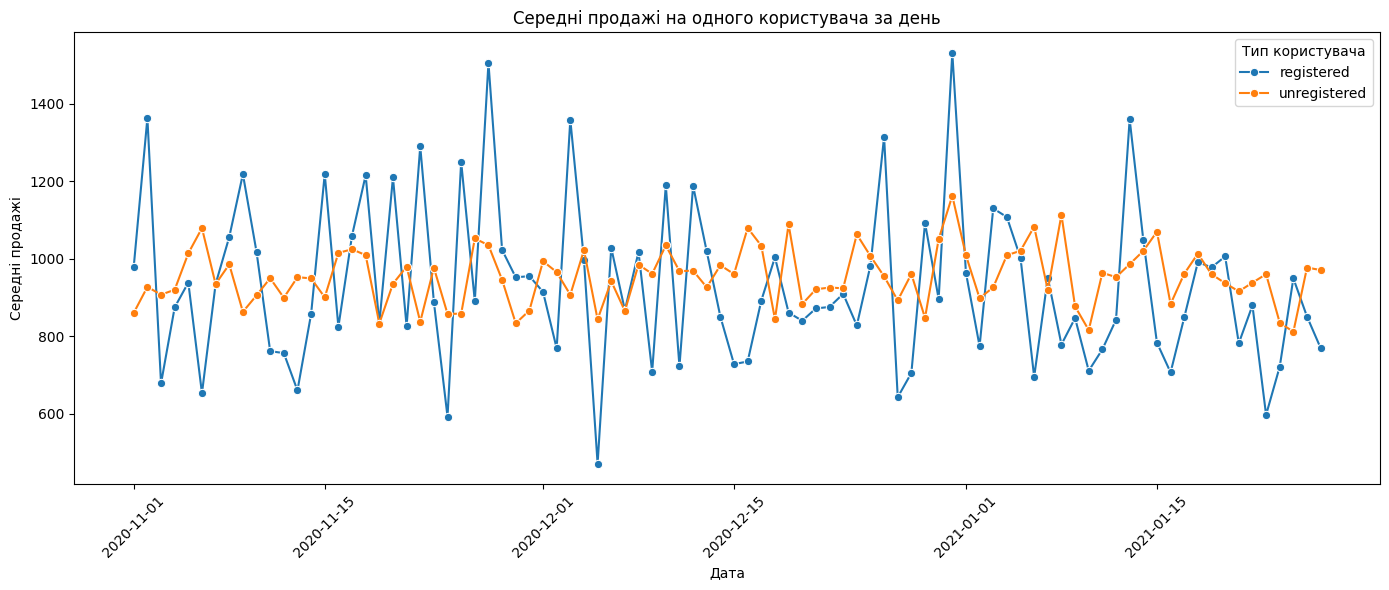

Медіана registered: 891.04375
Медіана unregistered: 953.1857875348467

Mann–Whitney U = 3155, p = 3.401e-02
Wilcoxon signed-rank: W = 1613, p = 1.511e-01


In [ ]:
df['user_type'] = df['is_email_verified'].apply(lambda x: 'registered' if x in [0,1] else 'unregistered')

agg = (
    df.groupby(['date','user_type'])
      .agg(total_sales=('product_price','sum'),
           n_users=('user_type','count'))
      .reset_index()
)

agg['avg_sales'] = agg['total_sales'] / agg['n_users']

pivot_avg = agg.pivot(index='date', columns='user_type', values='avg_sales').fillna(0)

plt.figure(figsize=(14,6))
sns.lineplot(
    data=pivot_avg.reset_index().melt(id_vars='date', var_name='user_type', value_name='avg_sales'),
    x='date', y='avg_sales', hue='user_type', marker="o"
)
plt.title('Середні продажі на одного користувача за день')
plt.xlabel('Дата')
plt.ylabel('Середні продажі')
plt.xticks(rotation=45)
plt.legend(title='Тип користувача')
plt.tight_layout()
plt.show()

reg = pivot_avg['registered'].values
unreg = pivot_avg['unregistered'].values

print("Медіана registered:", np.median(reg))
print("Медіана unregistered:", np.median(unreg))

mw = mannwhitneyu(reg, unreg, alternative='two-sided', method='asymptotic')
print(f"\nMann–Whitney U = {mw.statistic:.0f}, p = {mw.pvalue:.3e}")

diffs = pivot_avg['registered'] - pivot_avg['unregistered']
w_stat, w_p = wilcoxon(diffs, zero_method='pratt', alternative='two-sided', mode='auto')
print(f"Wilcoxon signed-rank: W = {w_stat:.0f}, p = {w_p:.3e}")


Mann–Whitney U test

U = 3155, p = 0.034 → при α = 0.05 різниця статистично значуща.

Це означає, що розподіли середніх продажів між групами відрізняються.

Wilcoxon signed-rank test (парний по датах)

W = 1613, p = 0.151 → різниця не є статистично значущою.

Якщо ми розглядаємо кожну дату як “пару спостережень” (зареєстровані vs незареєстровані в той самий день), то значущої різниці в середніх продажах немає.

Висновки

Якщо порівнювати групи як незалежні вибірки (Mann–Whitney) → незареєстровані користувачі статистично витрачають більше (медіана ~953 vs 891).

Якщо ж порівнювати в рамках кожного дня (Wilcoxon, більш строгий підхід) → різниця не досягає статистичної значущості (p > 0.05).

Це означає, що загалом тренд існує (незареєстровані трошки більше витрачають), але стабільно відтворюваним його назвати не можна — різниця “плаває” від дати до дати.


---


Загальний підсумок:

Незареєстровані користувачі в середньому здійснюють трохи більші покупки, ніж зареєстровані, але ця перевага не є стабільною в часі. При парному порівнянні по датах різниця втрачає статистичну значущість.

##Відмінності між каналами продаж

          channel  total_sales  average_sales  session_count
0          Direct    7494923.4     960.887615           7800
1  Organic Search   11433151.6     959.076554          11921
2     Paid Search    8511049.4     941.279518           9042
3   Social Search    2532105.7     932.292231           2716
4       Undefined    2000501.0     971.588635           2059


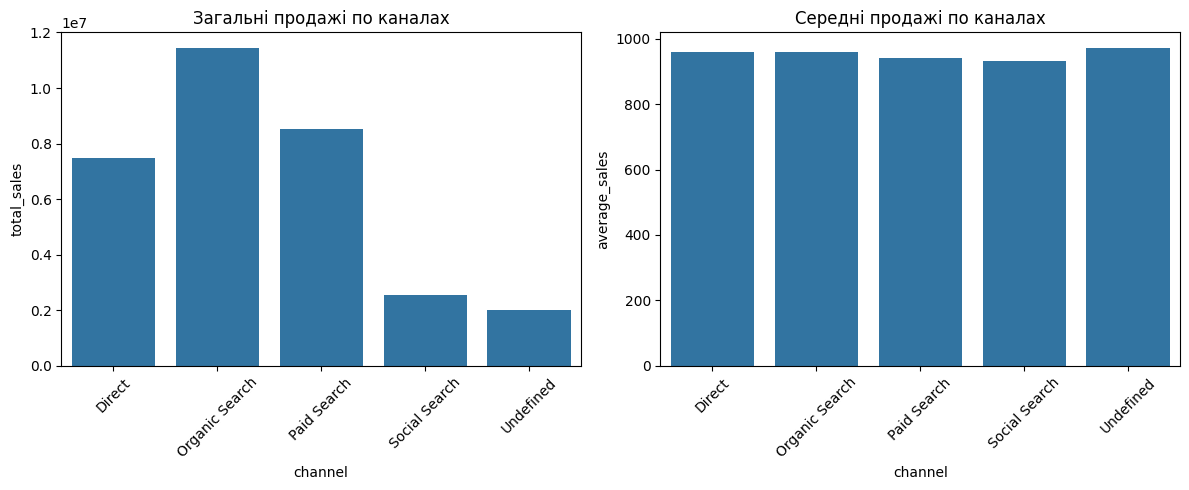

F-статистика: 0.582, p-value: 0.675
Статистично значущих відмінностей між каналами продажів не виявлено.
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1         group2     meandiff p-adj    lower    upper   reject
-----------------------------------------------------------------------
        Direct Organic Search  -1.8111    1.0  -54.1338  50.5116  False
        Direct    Paid Search -19.6081 0.8715  -75.1277  35.9115  False
        Direct  Social Search -28.5954 0.8668 -108.6419  51.4511  False
        Direct      Undefined   10.701 0.9975  -78.3154  99.7175  False
Organic Search    Paid Search  -17.797 0.8692  -67.9005  32.3064  False
Organic Search  Social Search -26.7843 0.8745 -103.1739  49.6052  False
Organic Search      Undefined  12.5121 0.9947  -73.2309   98.255  False
   Paid Search  Social Search  -8.9873  0.998  -87.6011  69.6265  False
   Paid Search      Undefined  30.3091 0.8803  -57.4212 118.0395  False
 Social Search      Undefined  

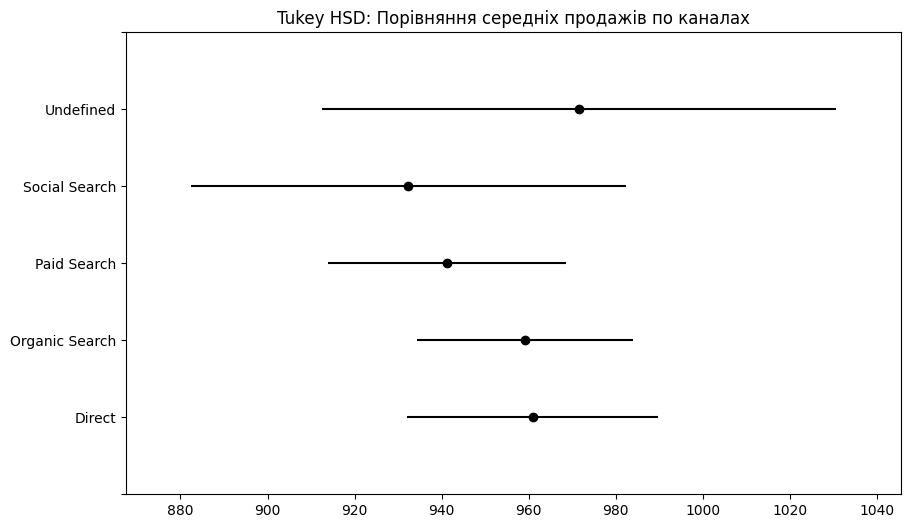

In [ ]:
channel_summary = df.groupby('channel').agg(
    total_sales=('product_price', 'sum'),
    average_sales=('product_price', 'mean'),
    session_count=('product_price', 'count')
).reset_index()

print(channel_summary)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.barplot(data=channel_summary, x='channel', y='total_sales')
plt.title('Загальні продажі по каналах')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.barplot(data=channel_summary, x='channel', y='average_sales')
plt.title('Середні продажі по каналах')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

sales_by_channel = [df[df['channel']==ch]['product_price'].values for ch in df['channel'].unique()]
f_stat, p_value = f_oneway(*sales_by_channel)
print(f"F-статистика: {f_stat:.3f}, p-value: {p_value:.3f}")

if p_value < 0.05:
    print("Є статистично значущі відмінності між каналами продажів.")
else:
    print("Статистично значущих відмінностей між каналами продажів не виявлено.")

tukey = pairwise_tukeyhsd(endog=df['product_price'],
                          groups=df['channel'],
                          alpha=0.05)

print(tukey)
tukey.plot_simultaneous(figsize=(10,6))
plt.title('Tukey HSD: Порівняння середніх продажів по каналах')
plt.show()


**Загальні продажі та середні продажі**

Загальні продажі:

Найбільші – у каналу Organic Search (11,4 млн), далі йдуть Paid Search (8,5 млн) та Direct (~7,5 млн).

Найменші – Social Search (2,5 млн) та Undefined (2 млн).
→ Це говорить про те, що більшість доходу приходить від органічного та платного пошуку.

Середні продажі на сесію:

Різниця між каналами мінімальна: від ~932 (Social Search) до ~972 (Undefined).

Графік показує, що середні продажі на сесію майже однакові для всіх каналів.

**Статистичний аналіз**

ANOVA тест:

F-статистика = 0.582, p-value = 0.675 → p > 0.05, тобто немає статистично значущої різниці середніх продажів на сесію між каналами.

Tukey HSD (post-hoc):

Всі значення reject = False → жодна пара каналів не показала статистично значущої різниці.

Навіть між каналами з найбільшими і найменшими середніми продажами (наприклад, Undefined vs Social Search) різниця не значуща.

**Висновок**

Незважаючи на те, що загальні продажі різні, середня вартість продажу на сесію по всіх каналах статистично однакова.

Це означає, що різниця в доході з каналів зумовлена кількістю сесій, а не ефективністю кожної сесії.

Для підвищення доходу варто зосередитися на каналах з великою кількістю сесій (Organic Search, Paid Search, Direct), а не на тих, де сесії менш численні.

##Доля сесій з органічним трафіком у Європі та Америці

Europe:  2238 / 6261 (35.75%)
Americas:  6536 / 18553 (35.23%)
Z-статистика: 0.739, p-value: 0.4600
❌ Статистично значущої різниці не виявлено.


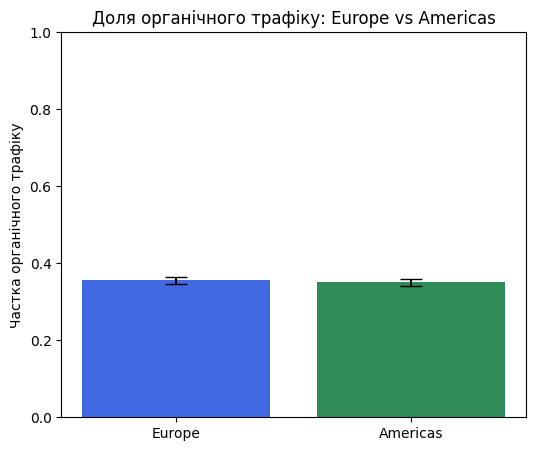

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# 1. Кількість сесій по континентах
sessions_by_continent = df.groupby('continent').size()

# 2. Кількість органічних сесій по континентах
organic_by_continent = df[df['channel']=="Organic Search"].groupby('continent').size()

# 3. Формуємо дані для тесту
n_Europe = sessions_by_continent['Europe']
k_Europe = organic_by_continent['Europe']

n_Americas = sessions_by_continent['Americas']
k_Americas = organic_by_continent['Americas']

print("Europe: ", k_Europe, "/", n_Europe, f"({k_Europe/n_Europe:.2%})")
print("Americas: ", k_Americas, "/", n_Americas, f"({k_Americas/n_Americas:.2%})")

# 4. Z-тест для двох пропорцій
count = [k_Europe, k_Americas]
nobs = [n_Europe, n_Americas]

stat, pval = proportions_ztest(count, nobs)
print(f"Z-статистика: {stat:.3f}, p-value: {pval:.4f}")

if pval < 0.05:
    print("✅ Є статистично значуща різниця у долі органічного трафіку між Європою та Америкою.")
else:
    print("❌ Статистично значущої різниці не виявлено.")

# 5. Довірчі інтервали для пропорцій
confint_Europe = proportion_confint(k_Europe, n_Europe, alpha=0.05, method='wilson')
confint_Americas = proportion_confint(k_Americas, n_Americas, alpha=0.05, method='wilson')

proportions = [k_Europe/n_Europe, k_Americas/n_Americas]
confints = [confint_Europe, confint_Americas]
labels = ['Europe', 'Americas']

# 6. Візуалізація
plt.figure(figsize=(6,5))
plt.bar(labels, proportions, yerr=[(top - prop, prop - low) for prop,(low,top) in zip(proportions, confints)],
        capsize=8, color=['royalblue', 'seagreen'])
plt.ylabel('Частка органічного трафіку')
plt.title('Доля органічного трафіку: Europe vs Americas')
plt.ylim(0, 1)
plt.show()


Висновок:

Органічний трафік в обох регіонах — Europe (35.75%) та Americas (35.23%) — є майже однаковим, і статистичний тест підтверджує, що ця різниця не є значущою (p = 0.4600). Відповідно, немає підстав вважати, що один регіон має кращий показник органічного трафіку, ніж інший.

#Tableau

https://public.tableau.com/shared/GNPYMMTN5?:display_count=n&:origin=viz_share_link